# Data Explorer

This notebook provides tools and visualizations to explore and analyze datasets in the project.

**Project:** CondGeoLDM  
**Author:** Pierre  
**Date:** 2024-06


## Basic file loading


In [2]:
import numpy as np
from rdkit import Chem
import numpy as np
from os.path import join
import pandas as pd

# charac = np.load("/projects/iktos/pierre/CondGeoLDM/data/jump/charac_30_h.npy", allow_pickle=True)
# charac[0]

In [3]:
import torch
args = np.load('/projects/iktos/pierre/CondGeoLDM/outputs/jump_xatt_improved/args.pickle',
                mmap_mode='r', 
                allow_pickle=True
                )
args
test = {'key': 'value'}

In [4]:
#TEMP
import argparse
def args_to_latex_string(args_dict, table_caption="Command Line Arguments", label="tab:args"):
    """
    Convert an argparse arguments dictionary to a LaTeX table string.
    
    Args:
        args_dict (dict): Dictionary of arguments (typically from vars(args))
        table_caption (str): Caption for the LaTeX table
        label (str): Label for the LaTeX table for referencing
    
    Returns:
        str: LaTeX table code as a string
    """
    
    # Start the LaTeX table
    latex_string = "\\begin{table}[htbp]\n"
    latex_string += "\\centering\n"
    latex_string += "\\begin{tabular}{|l|l|}\n"
    latex_string += "\\hline\n"
    latex_string += "\\textbf{Parameter} & \\textbf{Value} \\\\\n"
    latex_string += "\\hline\n"
    
    # Add each argument as a table row
    for key, value in args_dict.items():
        # Escape special LaTeX characters
        escaped_key = str(key).replace('_', '\\_').replace('%', '\\%').replace('$', '\\$').replace('&', '\\&').replace('#', '\\#')
        
        # Handle different value types and escape special characters
        if value is None:
            escaped_value = "None"
        elif isinstance(value, bool):
            escaped_value = str(value)
        elif isinstance(value, (list, tuple)):
            escaped_value = str(value).replace('_', '\\_').replace('%', '\\%').replace('$', '\\$').replace('&', '\\&').replace('#', '\\#')
        else:
            escaped_value = str(value).replace('_', '\\_').replace('%', '\\%').replace('$', '\\$').replace('&', '\\&').replace('#', '\\#')
        
        latex_string += f"{escaped_key} & {escaped_value} \\\\\n"
        latex_string += "\\hline\n"
    
    # Close the table
    latex_string += "\\end{tabular}\n"
    latex_string += f"\\caption{{{table_caption}}}\n"
    latex_string += f"\\label{{{label}}}\n"
    latex_string += "\\end{table}\n"
    
    return latex_string

print(args_to_latex_string(vars(args), table_caption="Command Line Arguments for jump_xatt_improved", label="tab:args_jump_xatt_improved"))

\begin{table}[htbp]
\centering
\begin{tabular}{|l|l|}
\hline
\textbf{Parameter} & \textbf{Value} \\
\hline
exp\_name & jump\_xatt\_improved \\
\hline
train\_diffusion & True \\
\hline
ae\_path & None \\
\hline
trainable\_ae & True \\
\hline
latent\_nf & 2 \\
\hline
kl\_weight & 0.01 \\
\hline
model & egnn\_dynamics \\
\hline
probabilistic\_model & diffusion \\
\hline
diffusion\_steps & 1000 \\
\hline
diffusion\_noise\_schedule & polynomial\_2 \\
\hline
diffusion\_noise\_precision & 1e-05 \\
\hline
diffusion\_loss\_type & l2 \\
\hline
n\_epochs & 200 \\
\hline
batch\_size & 78 \\
\hline
lr & 0.0001 \\
\hline
brute\_force & False \\
\hline
actnorm & True \\
\hline
break\_train\_epoch & False \\
\hline
dp & True \\
\hline
condition\_time & True \\
\hline
clip\_grad & True \\
\hline
trace & hutch \\
\hline
n\_layers & 4 \\
\hline
inv\_sublayers & 1 \\
\hline
nf & 256 \\
\hline
tanh & True \\
\hline
attention & True \\
\hline
norm\_constant & 1 \\
\hline
sin\_embedding & False \\
\hline
ode

In [5]:
%matplotlib inline
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolAlign
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from rdkit.Chem import rdDetermineBonds
import pandas as pd 

raw_data_path = pd.read_parquet( "/projects/iktos/pierre/CondGeoLDM/data/jump/raw_data/metadata.parquet")

def mol_from_inchi(inchi):
    """Convert InChI string to RDKit molecule."""
    mol = Chem.MolFromInchi(inchi, sanitize=False, removeHs=False)
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol, AllChem.ETKDG())
    
    if mol is None:
        raise ValueError("Failed to convert InChI to molecule")
    return mol

def mol_from_xyz_file(xyz_path):
    """Read XYZ file and create RDKit molecule with inferred bonds."""
    with open(xyz_path, 'r') as f:
        lines = f.readlines()
    
    # Parse XYZ format
    n_atoms = int(lines[0].strip())
    # Skip comment line
    atoms_data = lines[2:2+n_atoms]
    
    # Create editable molecule
    mol = Chem.RWMol()
    conf = Chem.Conformer(n_atoms)
    
    for i, line in enumerate(atoms_data):
        parts = line.strip().split()
        symbol = parts[0]
        x, y, z = map(float, parts[1:4])
        
        # Add atom
        atom = Chem.Atom(symbol)
        mol.AddAtom(atom)
        
        # Add coordinates
        conf.SetAtomPosition(i, (x, y, z))
    
    mol.AddConformer(conf)
    
    # mol = mol.GetMol()
    # mol = Chem.Mol(mol)
    # AllChem.EmbedMolecule(mol, AllChem.ETKDG())
    # mol = Chem.AddHs(mol)

    # Chem.SanitizeMol(mol)
    
    return mol

def get_coords(mol):
    conf = mol.GetConformer()
    return [conf.GetAtomPosition(i) for i in range(mol.GetNumAtoms())]

def plot_bonds_3d(ax, mol, coords, atom_color="blue"):
    """Plot bonds as lines between connected atoms."""
    xs, ys, zs = zip(*[(p.x, p.y, p.z) for p in coords])
    atom_colors = {
        1: "white", 6: "black", 7: "blue", 8: "red",
        9: "green", 15: "orange", 16: "yellow", 17: "green",
        35: "brown", 53: "purple"
    }
    colors = [atom_colors.get(atom.GetAtomicNum(), "pink") for atom in mol.GetAtoms()]
    ax.scatter(xs, ys, zs, c=colors, s=60, edgecolors="black")
    # Plot atoms
    
    # # Plot bonds
    # for bond in mol.GetBonds():
    #     atom1_idx = bond.GetBeginAtomIdx()
    #     atom2_idx = bond.GetEndAtomIdx()
        
    #     # Get coordinates of the two atoms
    #     x1, y1, z1 = xs[atom1_idx], ys[atom1_idx], zs[atom1_idx]
    #     x2, y2, z2 = xs[atom2_idx], ys[atom2_idx], zs[atom2_idx]
        
    #     # Draw line between atoms
    #     ax.plot([x1, x2], [y1, y2], [z1, z2], 'k-', linewidth=1, alpha=0.8)
    
    # Add atom labels
    for i, atom in enumerate(mol.GetAtoms()):
        ax.text(xs[i], ys[i], zs[i], atom.GetSymbol(), fontsize=10)


    
def align_and_rmsd(mol_ref, mol_fit):
    """
    Align mol_fit onto mol_ref, return (rmsd, aligned_mol).
    Both molecules are copied, so originals stay untouched.
    If a molecule has no conformer, a 3D conformer is generated.
    """
    mol1 = Chem.Mol(mol_ref)
    mol2 = Chem.Mol(mol_fit)
    
    # Ensure both molecules have conformers
    if mol1.GetNumConformers() == 0:
        mol1 = Chem.AddHs(mol1)
        AllChem.EmbedMolecule(mol1, AllChem.ETKDG())
    
    if mol2.GetNumConformers() == 0:
        mol2 = Chem.AddHs(mol2)
        AllChem.EmbedMolecule(mol2, AllChem.ETKDG())
    
    # Copy mol2 so original is unchanged
    mol2_aligned = Chem.Mol(mol2)
    
    # Compute alignment
    rmsd = rdMolAlign.AlignMol(mol2_aligned, mol1)
    print(f"RMSD = {rmsd:.3f} Å")
    return rmsd, mol2_aligned
# Read XYZ file


In [6]:
import threading
from typing import Optional, Union

import numpy as np
from openbabel import pybel
from rdkit import Chem
from rdkit.Chem import AllChem
from scipy.spatial.transform import Rotation
ArrT = np.ndarray

def _check_shape_len(arr, allowed, name="object"):
    num_dims = len(arr.shape)
    allowed = [allowed] if isinstance(allowed, int) else allowed
    if num_dims not in allowed:
        raise RuntimeError(f"Number of dimensions of {name} must be in {str(allowed)}, got {num_dims}")


def _check_dim_shape(arr, dim, allowed, name="object"):
    shape = arr.shape[dim]
    allowed = [allowed] if isinstance(allowed, int) else allowed
    if shape not in allowed:
        raise RuntimeError(f"Shape of {name} for dim {dim} must be in {allowed}, got {shape}")

class PeriodicTable:
    """Singleton class wrapper for the RDKit periodic table providing a neater interface"""

    _instance = None

    def __new__(cls):
        if cls._instance is None:
            cls._instance = super().__new__(cls)

        return cls._instance

    def __init__(self):
        self._table = Chem.GetPeriodicTable()

        # Just to be certain that vocab objects are thread safe
        self._pt_lock = threading.Lock()

    def atomic_from_symbol(self, symbol: str) -> int:
        with self._pt_lock:
            symbol = symbol.upper() if len(symbol) == 1 else symbol
            atomic = self._table.GetAtomicNumber(symbol)

        return atomic

    def symbol_from_atomic(self, atomic_num: int) -> str:
        with self._pt_lock:
            token = self._table.GetElementSymbol(atomic_num)

        return token

    def valence(self, atom: Union[str, int]) -> int:
        with self._pt_lock:
            valence = self._table.GetDefaultValence(atom)

        return valence


PT = PeriodicTable()

IDX_BOND_MAP = {1: Chem.BondType.SINGLE, 2: Chem.BondType.DOUBLE, 3: Chem.BondType.TRIPLE, 4: Chem.BondType.AROMATIC}
BOND_IDX_MAP = {bond: idx for idx, bond in IDX_BOND_MAP.items()}

IDX_CHARGE_MAP = {0: 0, 1: 1, 2: 2, 3: 3, 4: -1, 5: -2, 6: -3}
CHARGE_IDX_MAP = {charge: idx for idx, charge in IDX_CHARGE_MAP.items()}



In [7]:
import warnings
def mol_from_atoms(
    positions, atom_types: list[int], charges= None, sanitize=True, dataset_info=None
):
    """FROM SEMLA FLOW
    Create RDKit mol from atom coords and atom tokens (and optionally bonds)

    This function will create a partial molecule using the atomics and coordinates and then
    infer the bonds based on the coordinates using OpenBabel. 

    If charges are not provided they are assumed to be 0 for all atoms.

    Args:
        positions (torch.tensor)): Coordinate tensor, shape [n_atoms, 3]
        atom_type (torch.tensor]): Transformed from one_hot, length must be n_atoms
        bonds (np.ndarray, optional): Bond indices and types, shape [n_bonds, 3]
        charges (np.ndarray, optional): Charge for each atom, shape [n_atoms]
        sanitise (bool): Whether to apply RDKit sanitization to the molecule, default True

    Returns:
        Chem.rdchem.Mol: RDKit molecule or None if one cannot be created
    """
    if not getattr(mol_from_atoms, "_has_run", False):
        print("Building RDKit mols using Obabel bond inference.")
        mol_from_atoms._has_run = True
    coords=np.array(positions.tolist())  
    atomic_nb = [1, 5, 6, 7, 8, 9, 11, 14, 15, 16, 17, 19, 23, 33, 34, 35, 42, 50, 53, 80]
    atomics = [int(atomic_nb[i]) for i in atom_types]

    
    charges = charges.tolist() if charges is not None else [int(0)] * len(atomics)
    # Add atom types and charges
    mol = Chem.EditableMol(Chem.Mol())
    for idx, atomic in enumerate(atomics):
        atom = Chem.Atom(atomic)
        atom.SetFormalCharge(charges[idx])
        mol.AddAtom(atom)

    # Add 3D coords
    conf = Chem.Conformer(coords.shape[0])
    for idx, coord in enumerate(coords.tolist()):
        conf.SetAtomPosition(idx, coord)

    mol = mol.GetMol()
    mol.AddConformer(conf)
    
    # Infer bonds with OpenBabel
    coords = mol.GetConformer().GetPositions().tolist()
    coord_strs = ["\t".join([f"{c:.6f}" for c in cs]) for cs in coords]
    atom_symbols = [atom.GetSymbol() for atom in mol.GetAtoms()]

    xyz_str_header = f"{str(mol.GetNumAtoms())}\n\n"
    xyz_strs = [f"{str(atom)}\t{coord_str}" for coord_str, atom in zip(coord_strs, atom_symbols)]
    xyz_str = xyz_str_header + "\n".join(xyz_strs)
    for attempt in range(3):
        with warnings.catch_warnings(record=True) as w:
            warnings.simplefilter("always")
            try:
                pybel_mol = pybel.readstring("xyz", xyz_str)

                pybel_mol.OBMol.ConnectTheDots()
                pybel_mol.OBMol.SetAromaticPerceived(False)
                pybel_mol.OBMol.SetHybridizationPerceived(False)
                pybel_mol.addh()
                pybel_mol.OBMol.PerceiveBondOrders()

                
            # Add hydrogens for better bond inference

            except Exception:
                print("OpenBabel failed to read xyz string: caught exception")
                pybel_mol = None
                if w is None:
                    break
    if pybel_mol is None:
        print("OpenBabel failed to read xyz string: mol is None")
        return None

    mol_str = pybel_mol.write("mol")
    mol = Chem.MolFromMolBlock(mol_str, removeHs=False, sanitize=sanitize, strictParsing=False)
    return mol, mol_str
    

In [8]:
from metrics.viability import build_molecule, build_xae_molecule
from qm9.visualizer import load_xyz_files, load_molecule_xyz
from configs.datasets_config import get_dataset_info
from importlib import reload
from metrics import fidelity
import numpy as np
from skfp.distances.tanimoto import tanimoto_binary_similarity
import pandas as pd 
import matplotlib.pyplot as plt
pos, one_hot, charges = load_molecule_xyz(f"/projects/iktos/pierre/CondGeoLDM/sampled_mols/debug/eval/molecules/molecule_01_001.txt", dataset_info=dataset_info)
atom_type = one_hot.argmax(1).cpu().detach().tolist()
print(a_recon_s)
a_recon_s, mol_str = mol_from_atoms(positions=pos, 
                        atom_types=atom_type, 
                        charges=None,
                        sanitize=True
                        )
print(mol_str)
suppl = Chem.SDMolSupplier("/projects/iktos/pierre/CondGeoLDM/sampled_mols/debug/samples.sdf", sanitize=False, strictParsing=False)
mols = [mol for mol in suppl if mol is not None]
mols[0]

NameError: name 'dataset_info' is not defined

0
3


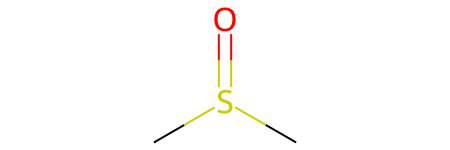

In [ ]:
# Load INCHIS FROM GT METADATA 
inchis_raw = raw_data_path['Metadata_InChI'].to_list()
a = Chem.MolFromInchi(inchis_raw[1], sanitize=False, removeHs=False)
print(a.GetNumConformers())
print(a.GetNumBonds())
a

In [9]:
%matplotlib inline

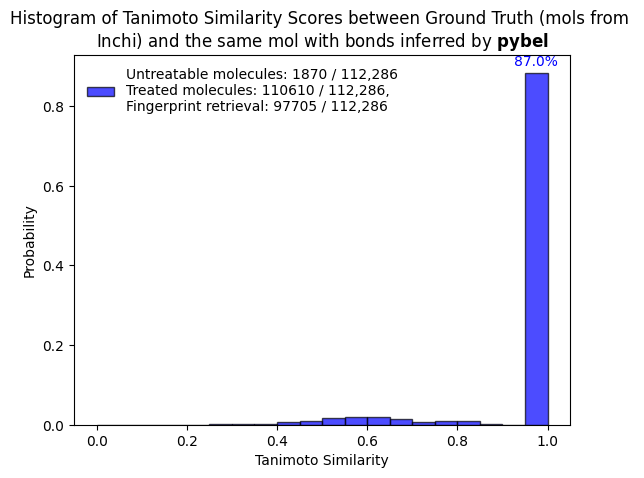

<Figure size 1200x800 with 0 Axes>

In [36]:
# # IMPORt CONDGEO FN
# from metrics.viability import build_molecule, build_xae_molecule
# from qm9.visualizer import load_xyz_files, load_molecule_xyz
# from configs.datasets_config import get_dataset_info
# from importlib import reload
# from metrics import fidelity
# import numpy as np
# from skfp.distances.tanimoto import tanimoto_binary_similarity
# import pandas as pd 
# import matplotlib.pyplot as plt

# raw_data_path = pd.read_parquet("/projects/iktos/pierre/CondGeoLDM/data/jump/raw_data/metadata.parquet")
# dataset_info = get_dataset_info('jump', remove_h=False)
# inchis_raw = raw_data_path['Metadata_InChI'].to_list()

# fps= []
# errors= 0
# mol_inchi = []
# untreatable_mol_inchi = []
# mol_recon = []
# for i in range(len(inchis_raw)):
#     try:
#         # GENERATE 3D CONFORMER
#         a =Chem.AddHs(Chem.MolFromInchi(inchis_raw[i], sanitize=True, removeHs=False))
#         AllChem.EmbedMolecule(a , AllChem.ETKDG())
        
#         # GENERATE XYZ FILE
#         conf = a.GetConformer(0)
#         n_atoms = a.GetNumAtoms()

#         lines = [str(n_atoms), "Generated by RDKit"]
#         for atom in a.GetAtoms():
#             pos = conf.GetAtomPosition(atom.GetIdx())
#             symbol = atom.GetSymbol()
#             lines.append(f"{symbol} {pos.x:.6f} {pos.y:.6f} {pos.z:.6f}")
#         # print("\n".join(lines))
#     except Exception:
#         errors += 1
#         continue
#     #SAVE AND RELOAD XYA
#     xyz_file = "\n".join(lines)
#     try:
#         with open(f"/projects/iktos/pierre/CondGeoLDM/temp/molecule2.xyz", 'w') as f:
#             f.write(xyz_file)
#         pos, one_hot, charges = load_molecule_xyz(f"/projects/iktos/pierre/CondGeoLDM/temp/molecule2.xyz", dataset_info)
#         atom_type = one_hot.argmax(1).cpu().detach().tolist()

#         a_recon_s, _ = mol_from_atoms(positions=pos, 
#                                 atom_types=atom_type, 
#                                 charges=None,
#                                 sanitize=True
#                                 )
#     except Exception:
#         errors += 1
#         untreatable_mol_inchi.append(a)
#         continue
#     # atom_type = one_hot.argmax(1).cpu().detach()
#     # try:
#     #     a_recon_s = build_molecule(pos, atom_type, dataset_info)
#     #     # a_recon_s = Chem.AddHs(a_recon_s)
#     #     # AllChem.EmbedMolecule(a_recon_s, AllChem.ETKDG())
#     #     Chem.SanitizeMol(a_recon_s)
#     # except Exception:
#     #     errors += 1
#     #     untreatable_mol_inchi.append(a)
#     #     continue

#     # COMPARE FP
#     if a_recon_s is None:
#         errors += 1
#         untreatable_mol_inchi.append(a)
#         continue
#     fp_recon_s = fidelity.rdkit_mols_to_fingerprints([a_recon_s])
#     fp_inchi = fidelity.rdkit_mols_to_fingerprints([a])
#     fps.append(tanimoto_binary_similarity(fp_recon_s, fp_inchi))
#     if fps[-1] != 1.0:
#         mol_inchi.append(a)
#         mol_recon.append(a_recon_s)
# print(f"Untreatable molecules: {errors} / 1000")
# print(f"Treated molecules: {len(fps)} / 1000")
# count=0
# for fp in fps:
#     if fp >0.95:
#         count+=1
# print(f"Fingerprint retrieval :{count} / 1000")
# # GRAPH SIMILARITY DISTRIBUTION

legend_text = [
    f"Untreatable molecules: {errors} / 112,286\nTreated molecules: {len(fps)} / 112,286,\nFingerprint retrieval: {count} / 112,286"

]
counts, bins = np.histogram(fps, bins=20, range=(0, 1))
probs = counts / counts.sum()
count_value = bins[-1]

# Get the center of the rightmost bin
x_position = (bins[-2] + bins[-1]) / 2
plt.bar(bins[:-1], probs, width=(bins[1]-bins[0]), 
        align='edge', alpha=0.7, color='blue', edgecolor='black')

plt.xlabel('Tanimoto Similarity')
plt.ylabel('Probability')
plt.text(x_position, count_value -0.1, f"{9770500/112286:.1f}"+'%', color='blue', ha='center')

plt.legend(legend_text, loc='upper left', frameon=False)  # place legend on left
plt.title('Histogram of Tanimoto Similarity Scores between Ground Truth (mols from \nInchi) and the same mol with bonds inferred by $\mathbf{pybel}$')
plt.figure(figsize=(12,8
                    ))
plt.tight_layout()
plt.show()
    

In [ ]:
Fingerprint retrieval: {count} / 112,286"
    f"Treated molecules: {len(fps)} / 112,286",
    f""
]
counts, bins = np.histogram(fps, bins=20, range=(0, 1))
probs = counts / counts.sum()
count_value = bins[-1]

# Get the center of the rightmost bin
x_position = (bins[-2] + bins[-1]) / 2
plt.bar(bins[:-1], probs, width=(bins[1]-bins[0]), 
        align='edge', alpha=0.7, color='blue', edgecolor='black')

plt.xlabel('Tanimoto Similarity')
plt.ylabel('Probability')
plt.text(x_position, count_value , str(int(count_value))+'%', color='blue', ha='center')

plt.legend(legend_text, loc='upper left', frameon=False)  # place legend on left
plt.title('Histogram of Tanimoto Similarity Scores between Ground Truth (mols from Inchi) \n  \
          and the same mol with bonds inferred by pybel - Sanitized')
# plt.show()
    

In [119]:
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display

n = 1  # nombre de paires à afficher
cols = 2

# Assure-toi que les listes sont au moins de longueur n
mol_pairs = list(zip(mol_inchi[0:1], mol_recon[0:1]))

# Aplatir la liste
mols_flat = [m for pair in mol_pairs for m in pair]

# Créer les légendes : "Original i", "Reconstructed i"
legends = [f"Original " if j % 2 == 0 else f"Reconstructed "
           for i in range(len(mol_pairs))
           for j in range(2)]

# Dessin de la grille
img = Draw.MolsToGridImage(
    mols_flat,
    molsPerRow=cols,
    subImgSize=(500,500),
    legends=legends
)

display(img)

[09:02:39] 

****
Pre-condition Violation
no draw context
Violation occurred on line 211 in file /project/build/temp.linux-x86_64-cpython-310/rdkit/Code/GraphMol/MolDraw2D/MolDraw2DCairo.cpp
Failed Expression: dp_cr
----------
Stacktrace:
----------
****



RuntimeError: Pre-condition Violation
	no draw context
	Violation occurred on line 211 in file Code/GraphMol/MolDraw2D/MolDraw2DCairo.cpp
	Failed Expression: dp_cr
	RDKIT: 2024.09.5
	BOOST: 1_85


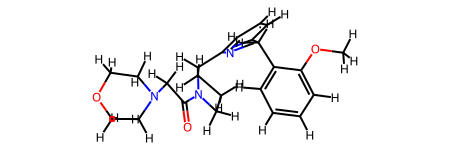

In [9]:
mol_inchi[1]

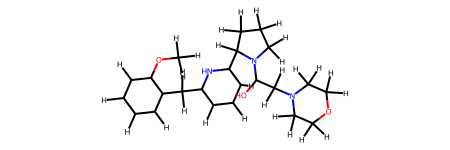

In [10]:
mol_recon[1]

1


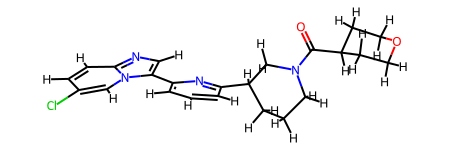

In [ ]:
# GENERATE 3D CONFORMER
a =Chem.AddHs(Chem.MolFromInchi(inchis_raw[1], sanitize=True, removeHs=False))
AllChem.EmbedMolecule(a , AllChem.ETKDG())
print(a.GetNumConformers())
a

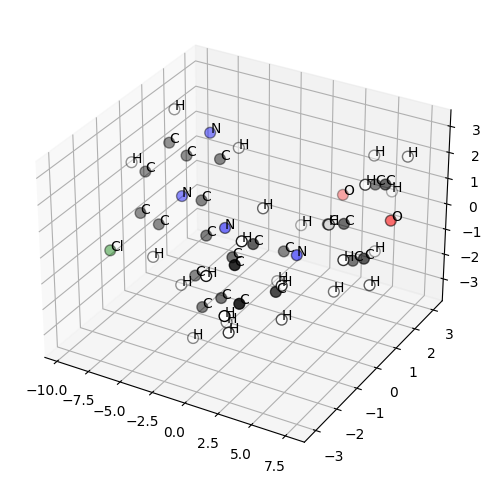

In [115]:
%matplotlib inline
# GENERATE XYZ FILE
conf = a.GetConformer(0)
n_atoms = a.GetNumAtoms()

lines = [str(n_atoms), "Generated by RDKit"]
for atom in a.GetAtoms():
    pos = conf.GetAtomPosition(atom.GetIdx())
    symbol = atom.GetSymbol()
    lines.append(f"{symbol} {pos.x:.6f} {pos.y:.6f} {pos.z:.6f}")
# print("\n".join(lines))

ax = plt.figure(figsize=(8, 6)).add_subplot(111, projection='3d')
plot_bonds_3d(ax, a, get_coords(a), atom_color="yellow")
plt.show()

RAW XYZ FILE:


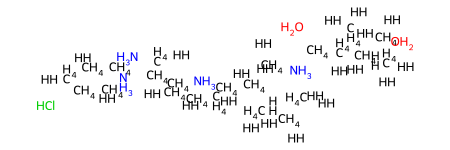

In [116]:
# SAVE AND RELOAD XYZ FILE
xyz_file = "\n".join(lines)
with open(f"/projects/iktos/pierre/CondGeoLDM/temp/molecule2.xyz", 'w') as f:
    f.write(xyz_file)
with open(f"/projects/iktos/pierre/CondGeoLDM/temp/molecule2.xyz", 'r') as f:
    lines = f.readlines()
print("RAW XYZ FILE:")
xyz_mol = mol_from_xyz_file(f"/projects/iktos/pierre/CondGeoLDM/temp/molecule2.xyz")
xyz_mol

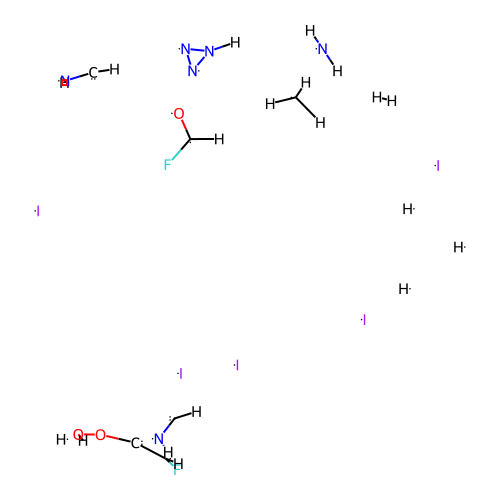

In [62]:
# IMPORt CONDGEO FN
from metrics.viability import build_molecule, build_xae_molecule
from qm9.visualizer import load_xyz_files, load_molecule_xyz
from configs.datasets_config import get_dataset_info
from importlib import reload
dataset_info = get_dataset_info('jump', remove_h=False)
pos, one_hot, charges = load_molecule_xyz(f"/projects/iktos/pierre/sampled_mols/jump/100xattimproved_e22/eval/molecules/molecule_01_011.txt", dataset_info)
atom_type = one_hot.argmax(1).cpu().detach().tolist()
d = Chem.Draw.MolToImage
a_recon_s, _ = mol_from_atoms(positions=np.array(pos.tolist()), 
                           atom_types=atom_type, 
                           charges=None,
                           )
d(a_recon_s, (500,500))


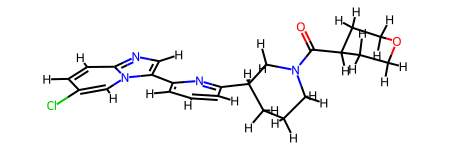

In [118]:
pos, one_hot, charges = load_molecule_xyz(f"/projects/iktos/pierre/CondGeoLDM/temp/molecule2.xyz", dataset_info)
atom_type = one_hot.argmax(1).cpu().detach().tolist()
# atomic_nb = [1, 5, 6, 7, 8, 9, 11, 14, 15, 16, 17, 19, 23, 33, 34, 35, 42, 50, 53, 80]
# atom_nb = [int(atomic_nb[i]) for i in atom_type]
charges = np.array(charges.reshape(-1), dtype=int)



a_recon_s, _ = mol_from_atoms(positions=np.array(pos.tolist()), 
                           atom_types=atom_type, 
                           charges=None,
                           )
a_recon_s


In [16]:
# COMPARE FP
from metrics import fidelity
import numpy as np
from skfp.distances.tanimoto import tanimoto_binary_similarity
fp_recon_s = fidelity.rdkit_mols_to_fingerprints([a_recon_s])
fp_inchi = fidelity.rdkit_mols_to_fingerprints([a])
tanimoto_binary_similarity(fp_recon_s, fp_inchi)

1.0

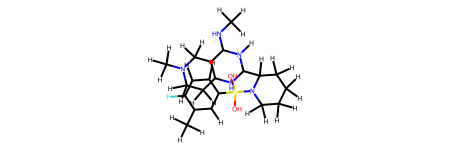

In [17]:
pos, one_hot, charges = load_molecule_xyz(f"/projects/iktos/pierre/CondGeoLDM/temp/molecule2.xyz", dataset_info)
atom_type = one_hot.argmax(1).cpu().detach()
a_recon = build_molecule(pos, atom_type, dataset_info)
# Chem.SanitizeMol(a_recon)

# mol_frags = Chem.rdmolops.GetMolFrags(a_recon, asMols=True)
# largest_mol = max(mol_frags, default=a_recon, key=lambda m: m.GetNumAtoms())
# a_recon = largest_mol
a_recon

1
RAW SDF FILE, NO SANITIZE:


[16:58:40] Failed to find a good bond to set as UP or DOWN for an atropisomer - atoms are: 28 24


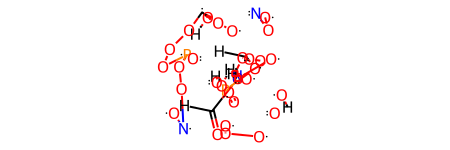

In [13]:
# CONVERT XYZ IN SDF : DONE IN OBABEL
    # OBABEL CREATES BONDS
# LOAD SDF FILE
a_sdf = Chem.SDMolSupplier('/projects/iktos/pierre/CondGeoLDM/temp/molecule2.sdf', sanitize=False, removeHs=False)[0]
print(a.GetNumConformers())
print("RAW SDF FILE, NO SANITIZE:")
a_sdf

In [84]:
# SANITIZING SDF
a_sdf_clean = Chem.Mol(a_sdf)
Chem.SanitizeMol(a_sdf_clean) #operates in place
# a_sdf_clean= Chem.AddHs(a_sdf_clean, addCoords=True)
Chem.GetMolFrags(a_sdf_clean)
AllChem.UFFOptimizeMolecule(a_sdf_clean, maxIters=200)

largest_frag = max(Chem.GetMolFrags(a_sdf_clean, asMols=True), key=lambda m: m.GetNumAtoms()    )
largest_frag
# count number of Hs
at = [atom.GetSymbol() for atom in largest_frag.GetAtoms() if atom.GetSymbol() == 'H'   ] 
len(at)

6

In [85]:
# COMPARE FP
from metrics import fidelity
import numpy as np
from skfp.distances.tanimoto import tanimoto_binary_similarity
fp_sdf = fidelity.rdkit_mols_to_fingerprints([largest_frag])
fp_sdf_1 = fidelity.rdkit_mols_to_fingerprints([a_sdf])
fp_inchi = fidelity.rdkit_mols_to_fingerprints([a])
tanimoto_binary_similarity(fp_sdf, fp_inchi), tanimoto_binary_similarity(fp_sdf_1, fp_inchi), tanimoto_binary_similarity(fp_sdf, fp_sdf_1)

(1.0, 1.0, 1.0)

Inchis from SDF = Inchi from file ? : False
RMSD = 2.521 Å


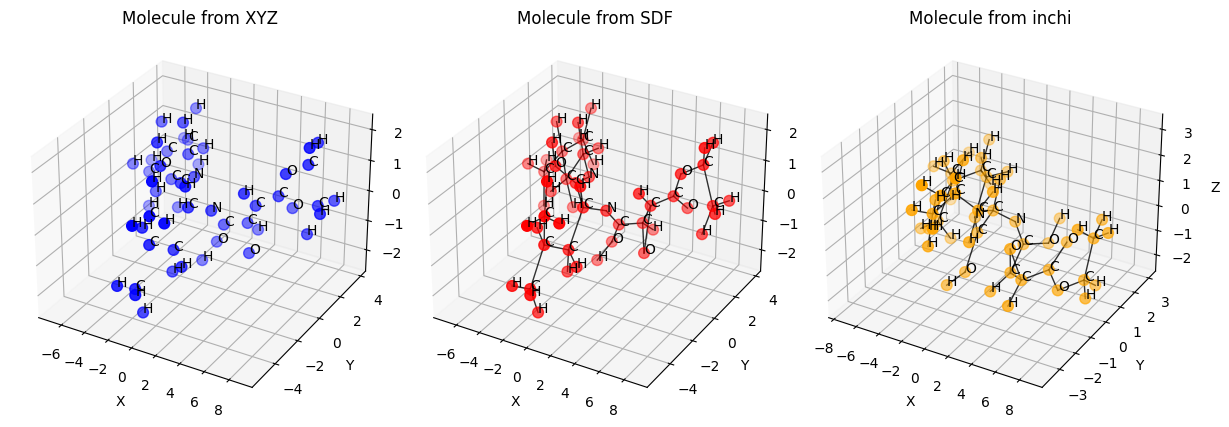

Inchis from SDF = Inchi from file ? : True
RMSD = 1.241 Å


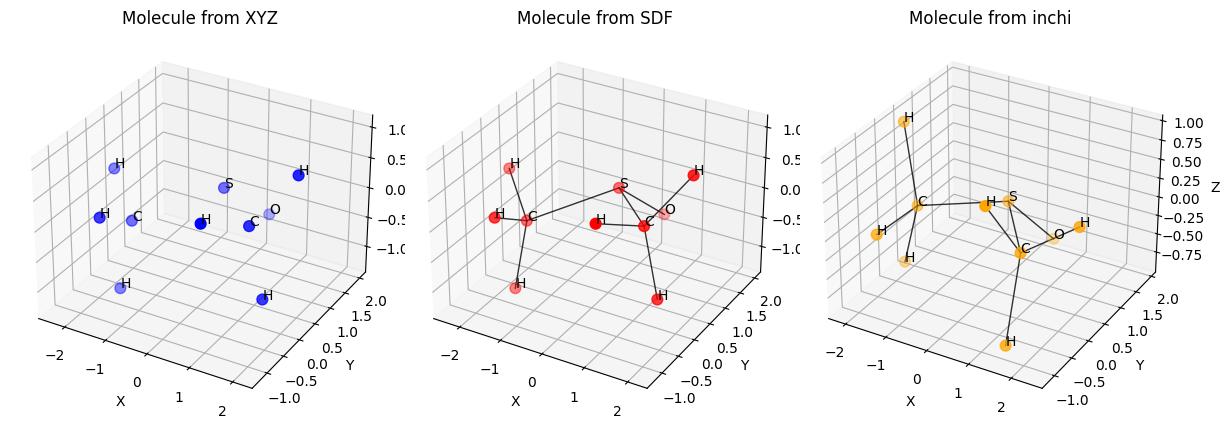

Inchis from SDF = Inchi from file ? : False
RMSD = 2.059 Å


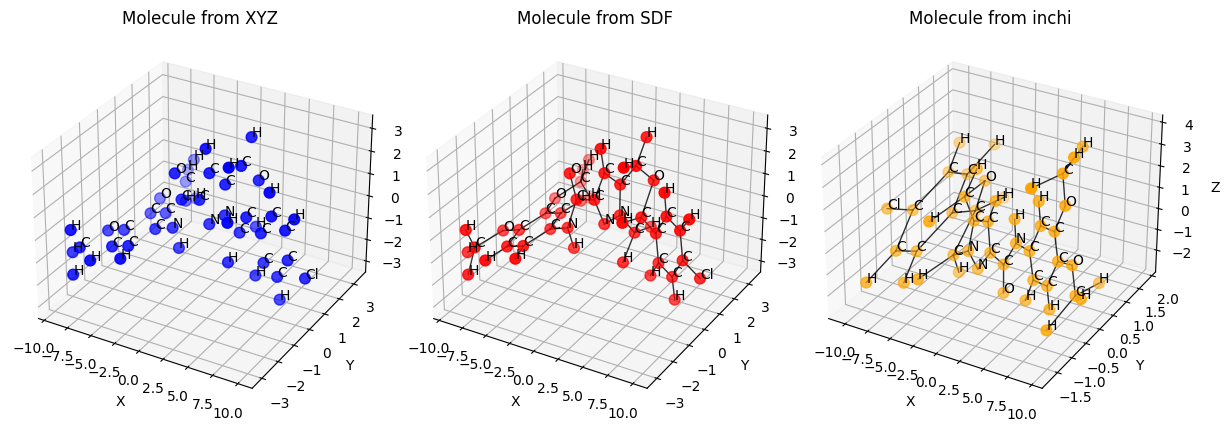

Inchis from SDF = Inchi from file ? : False
RMSD = 2.136 Å


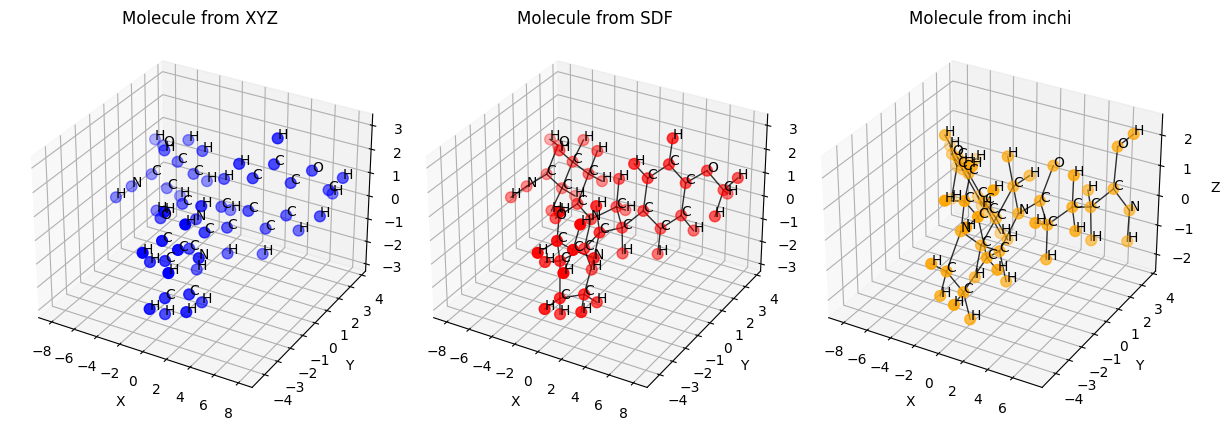

Inchis from SDF = Inchi from file ? : True
Alignment failed


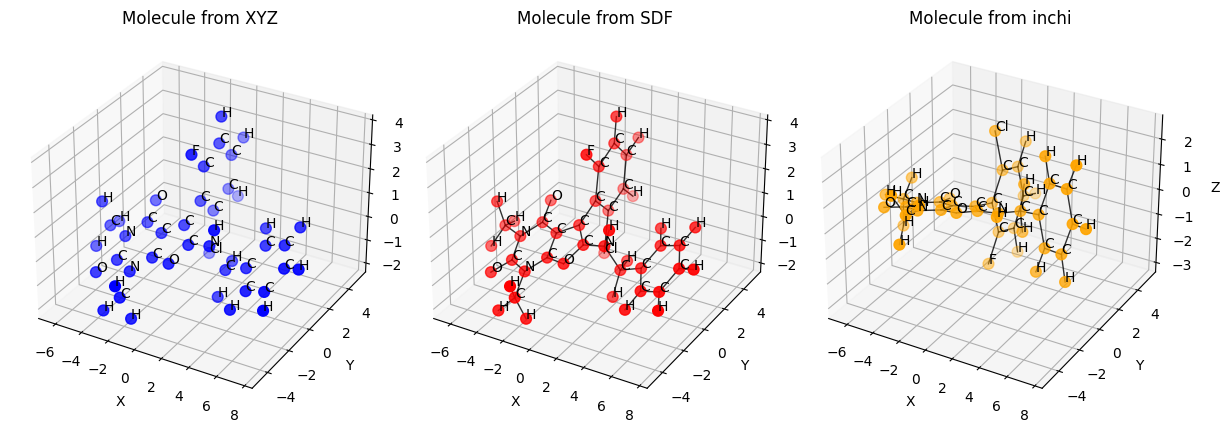

[16:03:26] tetrahedral chirality on atom with <3 or >4 neighbors will be ignored.


Inchis from SDF = Inchi from file ? : False
Alignment failed


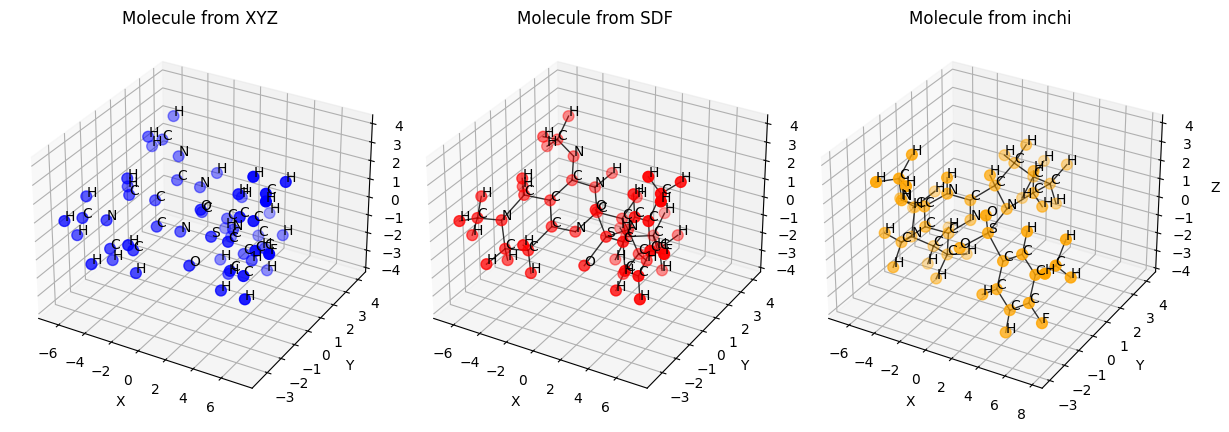

Inchis from SDF = Inchi from file ? : False
RMSD = 2.028 Å


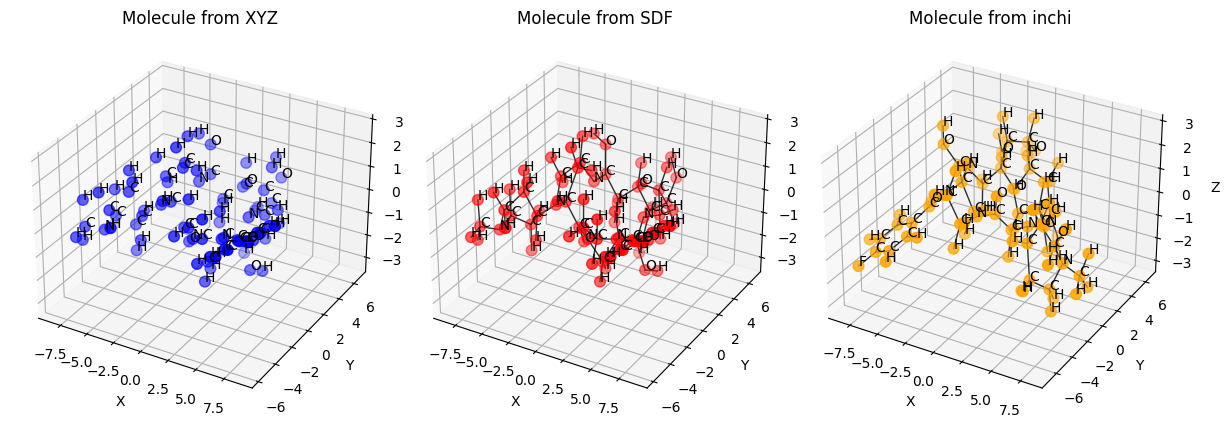

Inchis from SDF = Inchi from file ? : True
Alignment failed


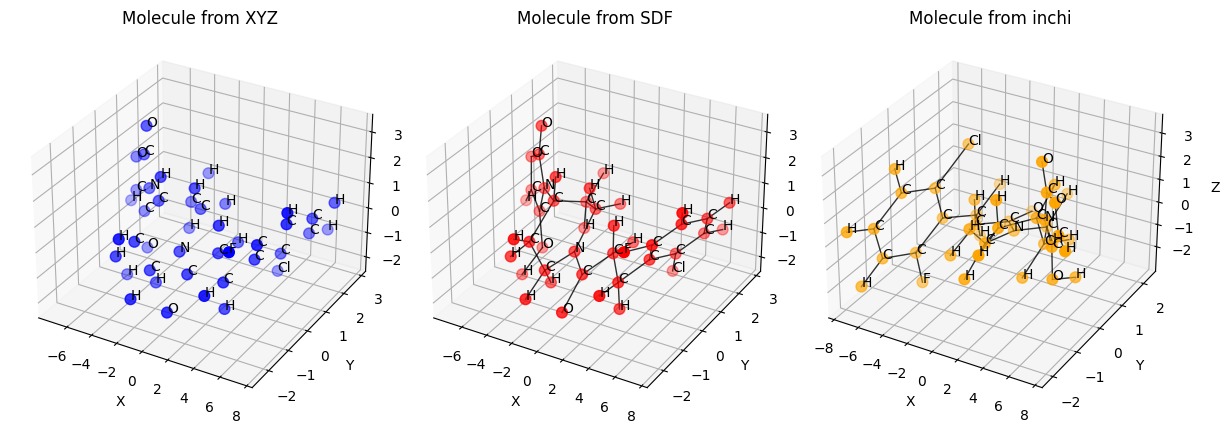

[16:03:30] Explicit valence for atom # 24 N, 4, is greater than permitted


AtomValenceException: Explicit valence for atom # 24 N, 4, is greater than permitted

In [14]:
from rdkit.Chem import rdMolAlign
raw_data_path = pd.read_parquet( "/projects/iktos/pierre/CondGeoLDM/data/jump/raw_data/metadata.parquet")
inchis_raw = raw_data_path['Metadata_InChI'].tolist()

for i in range(10):
     # --- Load molecules---
    xyz_path = f"/projects/iktos/pierre/CondGeoLDM/data/jump/raw_data/xyz_files/molecule{i}.xyz"
    mol_xyz = mol_from_xyz_file(xyz_path)

    sdf_path = "/projects/iktos/pierre/CondGeoLDM/data/jump/raw_data/jump_molecules_ordered.sdf"
    suppl = Chem.SDMolSupplier(sdf_path, sanitize=False, removeHs=False)
    mol_sdf = suppl[i]  # Get the i-th molecule
    mol_sdf_clean = Chem.Mol(mol_sdf)
    Chem.SanitizeMol(mol_sdf_clean)
    if mol_sdf is None:
        raise ValueError("Failed to read SDF file")
    temp = Chem.MolToInchi(mol_sdf)

    mol_inchi = mol_from_inchi(inchis_raw[i])
    print("Inchis from SDF = Inchi from file ? :", temp ==inchis_raw[i])
    coords_xyz = get_coords(mol_xyz)
    coords_sdf = get_coords(mol_sdf)
    coords_inchi = get_coords(mol_inchi)
        
    try :
        align_and_rmsd(mol_inchi, mol_sdf)
    except :
        print("Alignment failed")
    # --- Plot in 3D with bonds ---
    fig = plt.figure(figsize=(12, 6))

    ax1 = fig.add_subplot(131, projection="3d")
    ax1.set_title("Molecule from XYZ")
    plot_bonds_3d(ax1, mol_xyz, coords_xyz, atom_color="blue")
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')

    ax2 = fig.add_subplot(132, projection="3d")
    ax2.set_title("Molecule from SDF")
    plot_bonds_3d(ax2, mol_sdf, coords_sdf, atom_color="red")
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')

    ax3 = fig.add_subplot(133, projection="3d")
    ax3.set_title("Molecule from inchi")
    plot_bonds_3d(ax3, mol_inchi, coords_inchi, atom_color="orange")
    ax3.set_xlabel('X')
    ax3.set_ylabel('Y')
    ax3.set_zlabel('Z')

    plt.tight_layout()
    plt.show()

    
    


In [13]:
%matplotlib inline

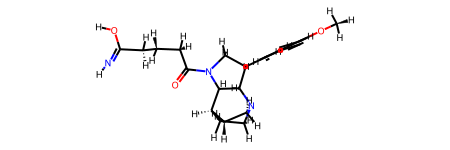

In [201]:
mol_sdf

## Modify args.pickle in checkpoints

In [8]:
import pickle
print(os.getcwd())
args_path = '/projects/iktos/pierre/CondGeoLDM/outputs/geom_pretrained/args.pickle'
with open(args_path, 'rb') as f:
    args_j = pickle.load(f)
args_j

#MODIFY YOUR ARGS HERE 
args_j.datadir = "/import/pr_iktos/pierre/CondGeoLDM"
# # # Uncomment to save args_j
with open(args_path, 'wb') as f:
    pickle.dump(args_j, f)

/import/pr_iktos/pierre/CondGeoLDM


# Tanimoto Similarities


In [5]:
import numpy as np
import pandas as pd
import metrics.fidelity as fidelity
from metrics.fidelity import compute_stacked_histogram, read_fingerprints_file
from importlib import reload
reload(fidelity)
# rax fp
geom_fp = read_fingerprints_file("/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/geom_fingerprints.npy")
jump_fp = read_fingerprints_file("/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/jump_fingerprints.npy")
self_sim_geom = np.load('/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/self_sim_geom.npy', allow_pickle=True)
self_sim_qm9 = np.load('/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/self_sim_qm9.npy', allow_pickle=True)

#refs
mal_jump_50k = np.load('/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/best_hits_jump_50k.npy', allow_pickle=True)
mal_qm9_20k= np.load('/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/best_hits_qm9_20k.npy', allow_pickle=True)
mal_geom_50k = np.load('/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/best_hits_geom_50k.npy', allow_pickle=True)

#mallat geom
mal_geoLDM = np.load('/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/best_hits_geoldm.npy', allow_pickle=True)
mal_semla = np.load('/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/best_hits_semla.npy', allow_pickle=True)
mal_flowmol = np.load('/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/best_hits_flowmol.npy', allow_pickle=True)
mal_gcdm= np.load('/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/best_hits_gcdm.npy', allow_pickle=True)

# mallat qm9
mal_semla_qm9 = np.load('/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/best_hits_semla_qm9.npy', allow_pickle=True)
mal_gcdm_qm9 = np.load('/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/best_hits_gcdm_qm9.npy', allow_pickle=True)
mal_semla_nopp = np.load('/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/best_hits_semla_nopp.npy', allow_pickle=True)

#mallat jump
mal_jumpxatt = np.load('/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/best_hits_jumpxatt.npy', allow_pickle=True)
mal_jumpvanilla = np.load('/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/best_hits_jumpvanilla.npy', allow_pickle=True)
mal_jump0 = np.load('/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/best_hits_jumpphen0.npy', allow_pickle=True)
mal_jump1 = np.load('/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/best_hits_jumpphen1.npy', allow_pickle=True)
mal_jump2 = np.load('/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/best_hits_jumpphen2.npy', allow_pickle=True)
print(len(geom_fp))

268658


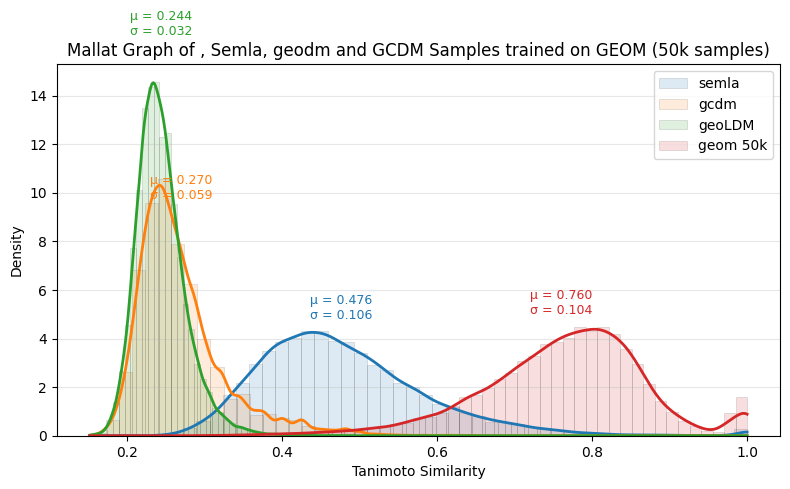

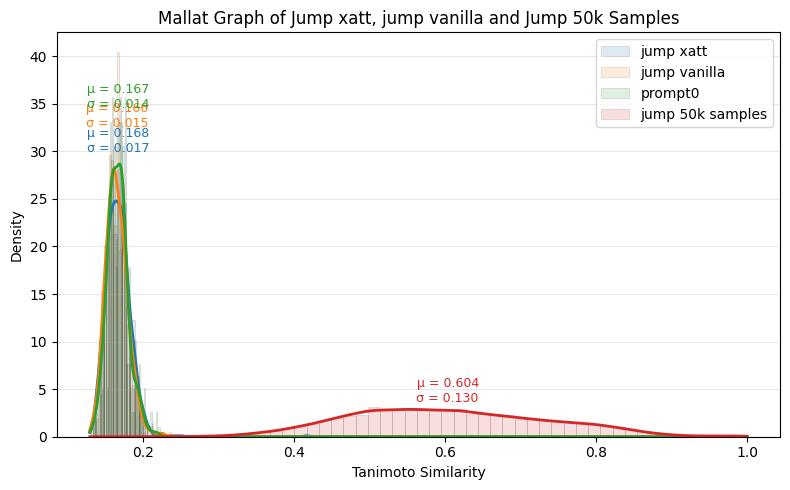

In [71]:

compute_stacked_histogram([mal_semla[:,0], mal_gcdm[:,0], mal_geoLDM[:,0], mal_geom_50k[:,0],  ],
                          labels=["semla","gcdm","geoLDM", "geom 50k"  ],
                          save_path="metrics/figures/mallat_test_global.png", 
                          bins=50,
                          title="Mallat Graph of , Semla, geodm and GCDM Samples trained on GEOM (50k samples)")
                          
                        #   labels= ["Similarities of Flowmol generations", "Similarities of Semla generations", "Similarities of GCDM generations", "Similarities of GEOM_50k"],
                        #   save_path="metrics/figures/mallat_global_50k.png", 
                        #   title="Mallat Graph of Flowmol, Semla and GCDM Samples trained on GEOM (50k samples)")

compute_stacked_histogram([mal_jumpxatt[:,0], mal_jumpvanilla[:,0], mal_jump0[:,0],mal_jump_50k[:,0]],
                          labels=["jump xatt", "jump vanilla" , "prompt0", "jump 50k samples"],
                          save_path="metrics/figures/mallat_jump_global.png", 
                          bins=50,
                          title="Mallat Graph of Jump xatt, jump vanilla and Jump 50k Samples")

## Test of fidelity metrics


In [2]:
import os
from metrics import fidelity
import numpy as np

import eval_script
import pickle
import torch
import argparse
from equivariant_diffusion.utils import assert_correctly_masked
from qm9.sampling import sample_chain, sample
import qm9.visualizer as vis
from qm9.models import get_latent_diffusion
from configs.datasets_config import get_dataset_info
from qm9 import dataset, losses
from metrics.viability import analyze_stability_for_molecules, check_stability
from importlib import reload
parser = argparse.ArgumentParser(
    description="Sample mol with conditioning drawn from clusters")

# parser.add_argument(
#     "--n_samples", type=int, default=10, help="Number of samples to generate")
# parser.add_argument(
#     "--n_tries",type=int, default=50,help="Number of tries to find stable molecules",)
# parser.add_argument(
#     "--data_file",type=str, default="/projects/iktos/pierre/CondGeoLDM/data/jump/charac_30_h.npy",
#     help="Conditioning type: geom, jump, or both")

# parser.add_argument("--model_path", type=str, default="/projects/iktos/pierre/CondGeoLDM/outputs/only_ae")
# parser.add_argument("--stable_only", type=bool, default="False")
# parser.add_argument("--visualise_chain", type=bool, default="False")
# parser.add_argument("--save_samples", type=bool, default = "False")
# parser.add_argument(
#     "--n_nodes",type=int, default=44 ,help="Size of fixed-sized generation")
# # Parse the arguments
# eval_args, _ = parser.parse_known_args()
# print(eval_args)
# assert eval_args.model_path is not None

# with open(os.path.join(eval_args.model_path, "args.pickle"), "rb") as f:
#     args = pickle.load(f)

# args.cuda = not args.no_cuda and torch.cuda.is_available()
# device = torch.device("cuda" if args.cuda else "cpu")
# args.device = device
# dtype = torch.float32

# # Retrieve dataset info and dataloaders
# dataset_info = get_dataset_info(args.dataset, args.remove_h)

# dataloaders, charge_scale = dataset.retrieve_dataloaders(args)

# flow, nodes_dist, prop_dist = get_latent_diffusion(
#     args, device, dataset_info, dataloaders["train"]
# )
# # if prop_dist is not None:
# #     property_norms = compute_mean_mad(dataloaders, args.conditioning, args.dataset)
# #     prop_dist.set_normalizer(property_norms)
# flow.to(device)

# fn = "generative_model_ema.npy" if args.ema_decay > 0 else "generative_model.npy"
# flow_state_dict = torch.load(os.path.join(eval_args.model_path, fn), map_location=device)
# flow.load_state_dict(flow_state_dict)

In [ ]:
sum(p.numel() for p in flow.parameters())
sum(p.numel() for p in flow.parameters() if p.requires_grad)

5482021

: 

In [12]:
vae_state_dict = flow.vae.state_dict()
vae_np_dict = {k: v.cpu().numpy() for k, v in vae_state_dict.items()}
torch.save(flow.vae.state_dict(), "/projects/iktos/pierre/CondGeoLDM/outputs/jump_xatt_h_3000%_25e_resume/vae/generative_model_ema.npy")

with open('outputs/jump_xatt_h_3000%_25e_resume/vae/args.pickle', 'wb') as f:
    pickle.dump(args, f)

In [ ]:
sum(p.numel() for p in flow.vae.parameters() if p.requires_grad)
sum(p.numel() for p in flow.vae.parameters() if p.requires_grad)

# flow

2373383


3108638

In [68]:
reload(eval_script)
one_hot, charges, x, node_mask = eval_script.sample_only_stable_different_sizes(
    args,
    eval_args,
    device,
    flow,
    nodes_dist,
    dataset_info,
    n_samples=50,
    n_tries=51,
    save=eval_args.save_samples,
)

0it [00:00, ?it/s]

1000it [06:12,  2.68it/s]


In [ ]:

reload(eval_script)
molecules_list = eval_script.graph_to_mol_list(one_hot=one_hot, charges=charges, x=x, node_mask=node_mask)
stability_dict, rdkit_metrics, mols = analyze_stability_for_molecules(
    molecules_list, 
    dataset_info,
    parallel=False
)
# TODO : GetLargestFragment(mol) change til les distances tanimoto ? 
print(stability_dict, rdkit_metrics)

Computing stability: 100%|██████████| 50/50 [00:03<00:00, 15.90it/s]
[15:43:36] Explicit valence for atom # 19 N, 4, is greater than permitted


Validity over 50 molecules: 98.00%

              Connectivity over 50 molecules: 40.00%
Uniqueness over 49 valid molecules: 100.00%
{'mol_stable': 0.0, 'atm_stable': 0.7734194739270881} [0.98, 1.0, 0.0, 0.4]


In [70]:
mols

In [ ]:
for i in range(mols.size()[0]):
    save_xyz_file(
        f"./temp/nul/{i}",
        one_hot[i].unsqueeze(0),
        charges[i].unsqueeze(0),
        x[i].unsqueeze(0),
        dataset_info,
        0,
        "",
        node_mask[i].unsqueeze(0))

In [18]:
# reload(fidelity)
from metrics import fidelity 

fp = fidelity.rdkit_mols_to_fingerprints(mols, fp_size=1024)
print(len(fp))
fidelity.save_fingerprints_file(fp, '/projects/iktos/pierre/CondGeoLDM/TEMPFP_jump')

39


In [21]:
# - visualiser les générations 
# Parameters
import matplotlib.pyplot as plt
from PIL import Image
n_images = 10
gen_folder = "temp/samples"
gt_folder = "temp/gt"

# Prepare image grid
fig, axes = plt.subplots(n_images, 2, figsize=(6, n_images * 2.5))

for i in range(n_images):
    # File names
    gen_path = os.path.join(gen_folder, f"{i}_01_000.png")
    gt_path = os.path.join(gt_folder, f"gt{i}_01_000.png")

    # Load images
    gen_img = Image.open(gen_path)
    gt_img = Image.open(gt_path)

    # Plot
    axes[i, 0].imshow(gt_img)
    axes[i, 0].set_title(f"GT {i}, similarity {ret3[i]:4f}")
    axes[i, 1].imshow(gen_img)
    axes[i, 1].set_title(f"Generated {i}")

    for j in range(2):
        axes[i, j].axis("off")

plt.tight_layout()
plt.savefig("temp/grid.png")
plt.show()


/tmp/ipykernel_2261705/2814354691.py:32: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


## Umap on both DS

The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.


/projects/iktos/pierre/CondGeoLDM/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/projects/iktos/pierre/CondGeoLDM/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


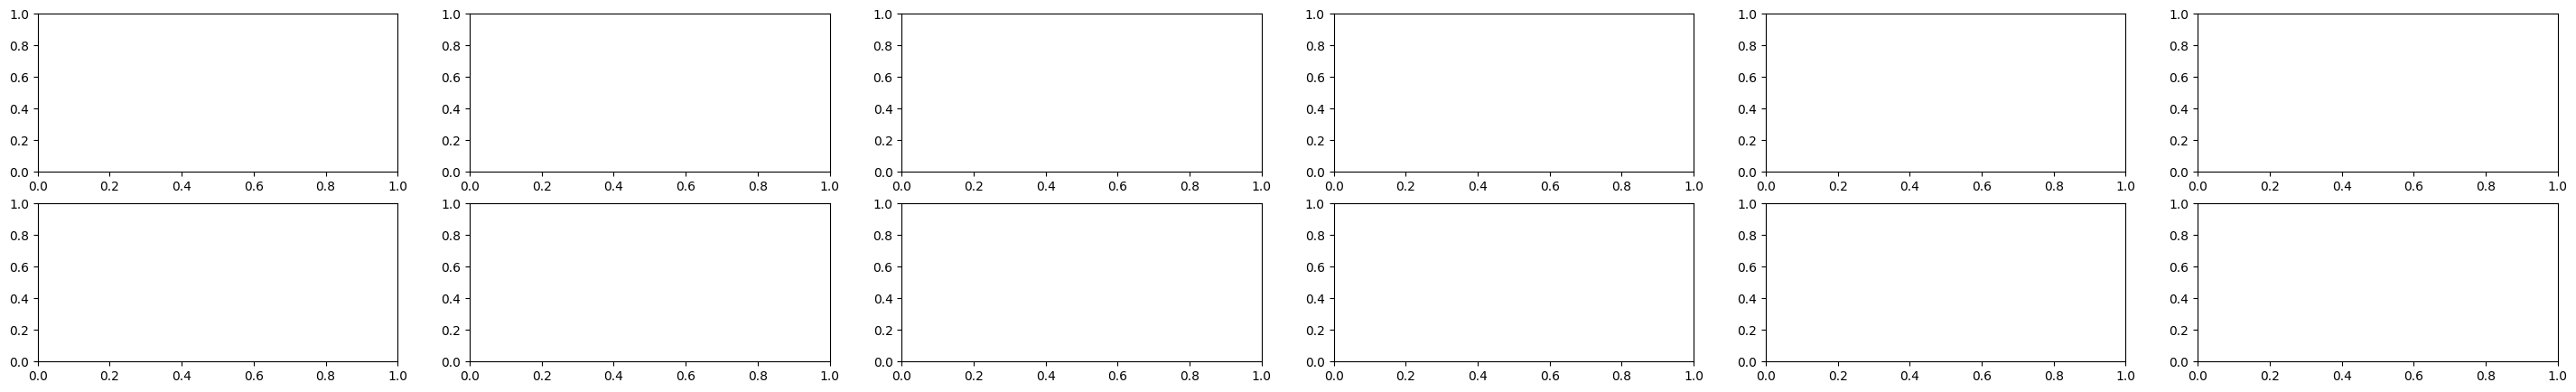

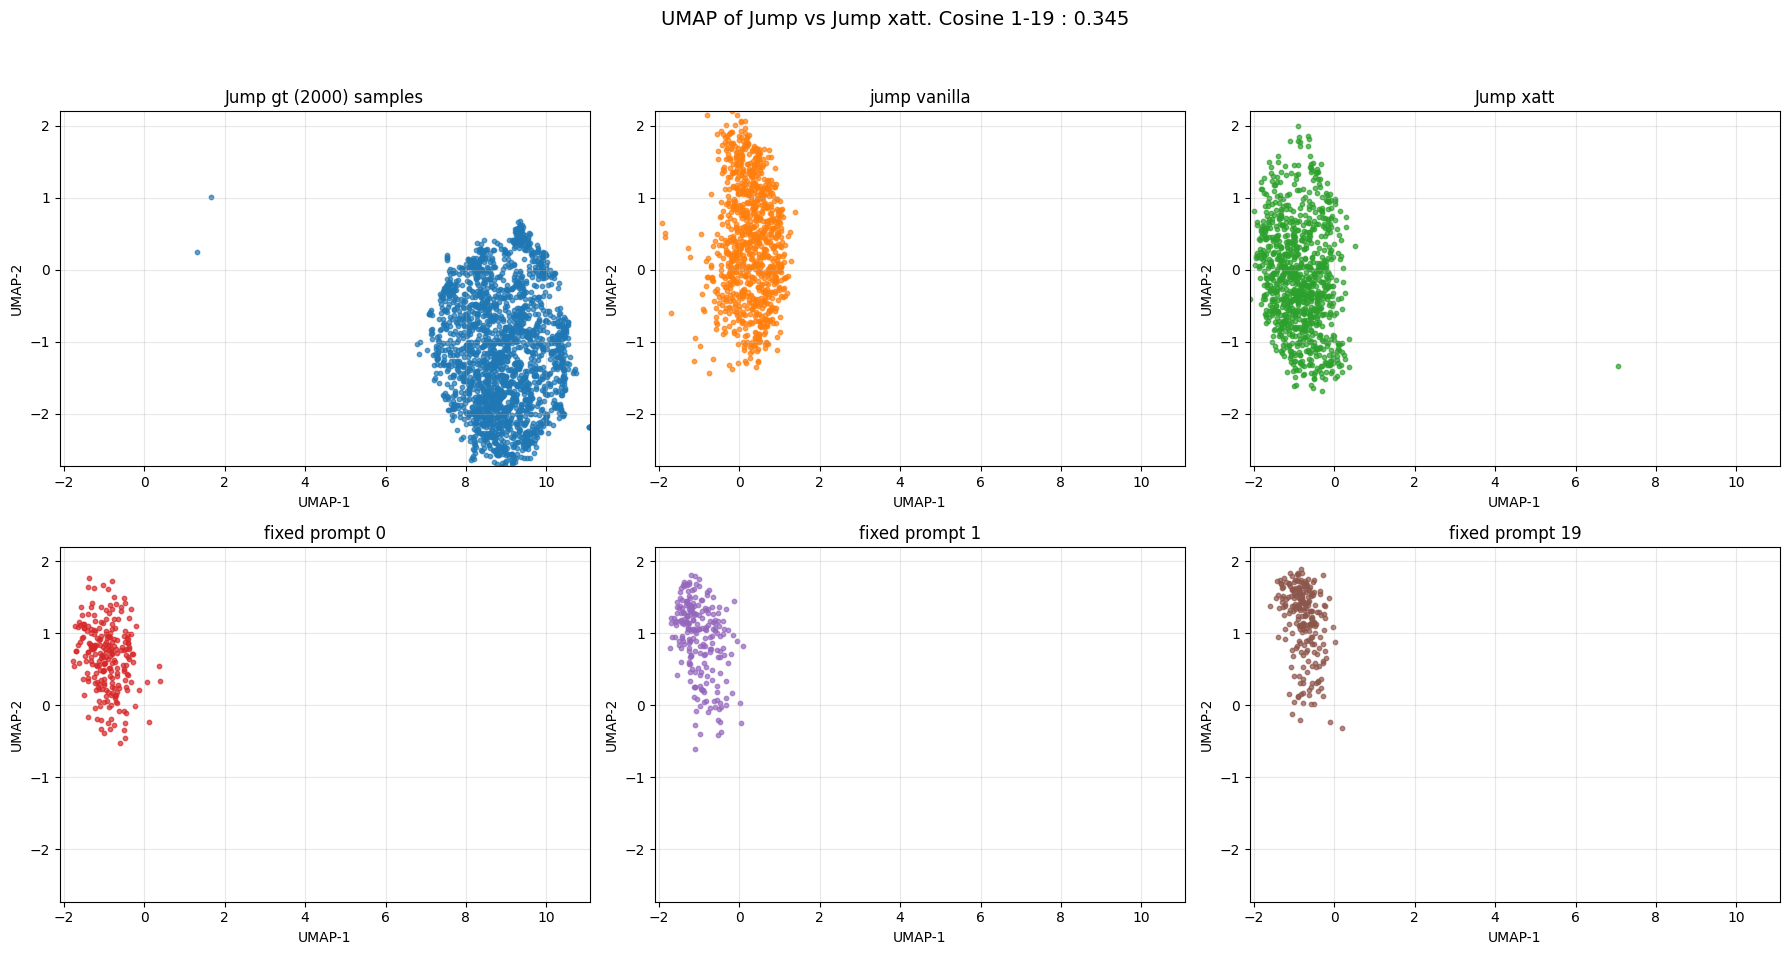

In [69]:
import metrics.fidelity as fidelity
reload(fidelity)
mask = np.random.choice(len(jump_fp), size=2000, replace=False)
vanilla_fp = fidelity.read_fingerprints_file("/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/fp_jumpvanilla_from_jump.npy")
xatt_fp = fidelity.read_fingerprints_file("/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/fp_jumpxatt_from_jump.npy")
prompt1_fp = fidelity.read_fingerprints_file("/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/fp_jumpphen0_from_jump.npy")
prompt2_fp = fidelity.read_fingerprints_file("/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/fp_jumpphen1_from_jump.npy")
prompt3_fp = fidelity.read_fingerprints_file("/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/fp_jumpphen2_from_jump.npy")
prompt19_fp = fidelity.read_fingerprints_file("/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/fp_jumpphen19_from_jump.npy")
fidelity.compute_stacked_umap([jump_fp[mask], vanilla_fp, xatt_fp, prompt1_fp, prompt2_fp, prompt19_fp],
                              labels=[f"Jump gt ({len(mask)}) samples", "jump vanilla", "Jump xatt", "fixed prompt 0", "fixed prompt 1", "fixed prompt 19"],
                              save_path="metrics/figures/umap_jump_vs_xatt.png",
                              title="UMAP of Jump vs Jump xatt. Cosine 1-19 : 0.345",)

In [ ]:
from pathlib import Path
import pickle
from qm9 import dataset

io_path = Path("/import/pr_iktos/pierre/CondGeoLDM")

with open(io_path / "outputs/jump_xatt_h_3000%_25e_resume" /  "args.pickle", "rb") as f:
    args = pickle.load(f)
dataloaders, _ = dataset.retrieve_dataloaders(args)

In [ ]:
test_loader = dataloaders["test"]
for batch in test_loader:
    emb = batch["embeddings"].clone()
    break
emb[0]

tensor([ 0.3145, -0.2783, -0.2576,  ...,  0.3796,  0.6060, -0.2661])

In [66]:
import torch.nn.functional as F

cos_sim01 = F.cosine_similarity(emb[1], emb[0], dim=0)
print("Cosine between prompts 0 & 1:" , cos_sim01)
cos_sim02 = F.cosine_similarity(emb[0], emb[19], dim=0)
print("Cosine between 0 & 19:", cos_sim02)
cos_sim12 = F.cosine_similarity(emb[1], emb[19], dim=0)
print("Cosine between 1 & 19:", cos_sim12)

Cosine between prompts 0 & 1: tensor(-0.0071)
Cosine between 0 & 19: tensor(-0.0706)
Cosine between 1 & 19: tensor(0.3402)


New min sim: -0.007125344127416611 between 0 and 1
New max sim: 0.05235643312335014 between 0 and 2
New min sim: -0.027340516448020935 between 0 and 3
New max sim: 0.19343121349811554 between 0 and 5
New min sim: -0.046828702092170715 between 0 and 8
New min sim: -0.14918577671051025 between 0 and 14
New max sim: 0.3401736915111542 between 1 and 19
New min sim: -0.1583302766084671 between 5 and 24
New min sim: -0.16041503846645355 between 8 and 26
New min sim: -0.34788158535957336 between 12 and 14


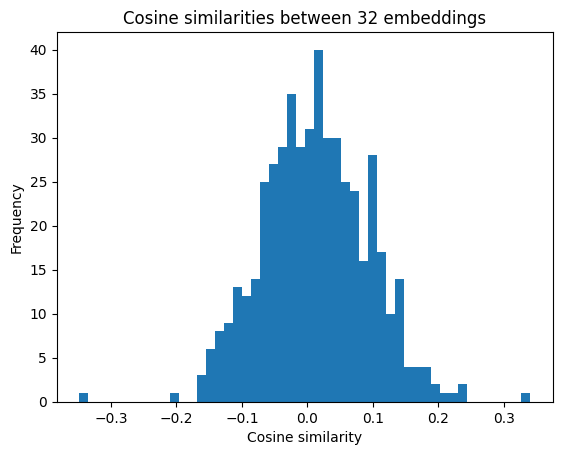

In [63]:
max_sim = 0
min_sim = 0
all_cos_sims = []
for i in range(emb.size()[0]):
    for j in range(i+1, emb.size()[0]):
        cos_sim = F.cosine_similarity(emb[i], emb[j], dim=0)
        all_cos_sims.append(cos_sim.item())
        if (cos_sim)> max_sim:
            max_sim = cos_sim
            print(f"New max sim: {max_sim} between {i} and {j}")
        if (cos_sim) < min_sim:
            min_sim = cos_sim
            print(f"New min sim: {min_sim} between {i} and {j}")

# plot all cosi histogram 

import matplotlib.pyplot as plt
plt.hist(all_cos_sims, bins=50)
plt.title("Cosine similarities between 32 embeddings")
plt.xlabel("Cosine similarity")
plt.ylabel("Frequency")     
# plt.savefig("metrics/figures/cosine_similarities_histogram.png")
plt.show() 

In [ ]:
def sample_chain(args, device, flow, n_tries, dataset_info, prop_dist=None, 
                 random_idx=True, n_samples=4):
    if args.dataset == 'qm9' or args.dataset == 'qm9_second_half' or args.dataset == 'qm9_first_half':
        n_nodes = 19
    elif args.dataset == 'geom' :
        n_nodes = 30
    elif args.dataset == 'jump' and args.remove_h:
        n_nodes = 30
    elif args.dataset == 'jump' and not args.remove_h:
        n_nodes = 44
    else:
        raise ValueError()

    
    # TODO FIX: This conditioning just zeros.
    if args.context_node_nf > 0:
        context = prop_dist.sample(n_nodes).unsqueeze(1).unsqueeze(0)
        context = context.repeat(1, n_nodes, 1).to(device)
        #context = torch.zeros(n_samples, n_nodes, args.context_node_nf).to(device)
    else:
        context = None
    if args.conditioning_mode == 'attention':
        # samples phenotypes for cross-attention conditioning from the train loaders
        phenotypes = np.load('/projects/iktos/pierre/CondGeoLDM/data/jump/train_embeddings.npy',
                mmap_mode='r', 
                allow_pickle=True
                )
        print("WE ARE CONDITIONING YAY")
        if random_idx:
            random_embedding_idx = torch.randint(0, phenotypes.shape[0], (n_samples,))
            phenotypes_to_sample_with = phenotypes[random_embedding_idx]
        else:
            # phenotypes = all_phenotypes[:batch_size]
            phenotypes_to_sample_with = phenotypes[14].repeat(n_samples, 1).to(device)  
        phenotypes = phenotypes_to_sample_with
    else:
        phenotypes = None
        
    # node_mask = torch.ones(n_samples, n_nodes, 1).to(device)
    # edge_mask = (1 - torch.eye(n_nodes)).unsqueeze(0)
    # edge_mask = edge_mask.repeat(n_samples, 1, 1).view(-1, 1).to(device)
    nodesxsample = [n_nodes - (i*5) for i in range(n_samples)]
    nodesxsample = torch.tensor(nodesxsample)
    node_mask = torch.zeros(n_samples, max(nodesxsample))
    for i in range(n_samples):
        node_mask[i, 0:nodesxsample[i]] = 1

    # Compute edge_mask

    edge_mask = node_mask.unsqueeze(1) * node_mask.unsqueeze(2)
    diag_mask = ~torch.eye(edge_mask.size(1), dtype=torch.bool).unsqueeze(0)
    edge_mask *= diag_mask
    edge_mask = edge_mask.view(n_samples * max(nodesxsample) * max(nodesxsample), 1).to(device)
    node_mask = node_mask.unsqueeze(2).to(device)
    keep_frames = min(40, args.n_stability_samples)
    if args.probabilistic_model == 'diffusion':
        one_hot, charges, x = None, None, None
        for i in range(n_tries):
            chain = flow.sample_chain(n_samples, n_nodes, node_mask, edge_mask, context, phenotypes, keep_frames=keep_frames)

            # chain = chains[:chains.size(0) //n_samples] # take only the first chain
            chain = reverse_tensor(chain)
        
            chain = chain.permute(1,0,2,3) # (n_samples, n_frames, n_nodes, 4 + args.include_charges)

            # Repeat last frame to see final sample better.
            chain = torch.cat([chain, chain[:, -1:, :, :].repeat(1, 10, 1, 1)], dim=1)
            x = chain[:, -1:, :, 0:3]
            one_hot = chain[:, -1:, :, 3:-1]
            one_hot = torch.argmax(one_hot, dim=3)

            atom_type = one_hot[0].squeeze(0).cpu().detach().numpy()
            x_squeeze = x[0].squeeze(0).cpu().detach().numpy()
            mol_stable = check_stability(x_squeeze, atom_type, dataset_info)[0]

            # Prepare entire chain.
            x = chain[:, :, :, 0:3]
            one_hot = chain[:, :, :, 3:-1]
            one_hot = F.one_hot(torch.argmax(one_hot, dim=3), num_classes=len(dataset_info['atom_decoder']))
            charges = torch.round(chain[:, :, :, -1:]).long()
            node_mask_final = node_mask.unsqueeze(1).repeat(1, chain.size(1), 1, 1).to(device)
            if mol_stable:
                print('Found stable molecule to visualize :)')
                break
            elif i == n_tries - 1:
                print('Did not find stable molecule, showing last sample.')

    else:
        raise ValueError

    return one_hot, charges, x, node_mask_final


def sample(args, device, generative_model, dataset_info,
           prop_dist=None, nodesxsample=torch.tensor([10]), context=None, phenotypes=None,
           fix_noise=False, random_idx=False):
    max_n_nodes = dataset_info['max_n_nodes']  # this is the maximum node_size in QM9

    assert int(torch.max(nodesxsample)) <= max_n_nodes
    batch_size = len(nodesxsample)

    node_mask = torch.zeros(batch_size, max_n_nodes)
    for i in range(batch_size):
        node_mask[i, 0:nodesxsample[i]] = 1

    # Compute edge_mask

    edge_mask = node_mask.unsqueeze(1) * node_mask.unsqueeze(2)
    diag_mask = ~torch.eye(edge_mask.size(1), dtype=torch.bool).unsqueeze(0)
    edge_mask *= diag_mask
    edge_mask = edge_mask.view(batch_size * max_n_nodes * max_n_nodes, 1).to(device)
    node_mask = node_mask.unsqueeze(2).to(device)

    if args.context_node_nf > 0:
        if context is None:
            context = prop_dist.sample_batch(nodesxsample)
        context = context.unsqueeze(1).repeat(1, max_n_nodes, 1).to(device) * node_mask
    else:
        context = None
    if args.conditioning_mode == 'attention':
        # samples phenotypes for cross-attention conditioning from the test loaders
        phenotypes = np.load('/projects/iktos/pierre/CondGeoLDM/data/jump/train_embeddings.npy',
        mmap_mode='r', 
        allow_pickle=True
        )
        print("WE ARE CONDITIONING YAY")
        if random_idx:
            random_embedding_idx = torch.randint(0, phenotypes.shape(0), (batch_size,))
            phenotypes_to_sample_with = torch.from_numpy(phenotypes[random_embedding_idx].copy()).to(device)
        else:
            chosen_phen = torch.from_numpy(phenotypes[14].copy())
            phenotypes_to_sample_with = chosen_phen.repeat(batch_size, 1).to(device)  
    else:
        phenotypes = None
    
    if args.probabilistic_model == 'diffusion':
        x, h = generative_model.sample(batch_size, max_n_nodes, node_mask, edge_mask, context, 
                                       phenotypes_to_sample_with, fix_noise=fix_noise)

        assert_correctly_masked(x, node_mask)
        assert_mean_zero_with_mask(x, node_mask)

        one_hot = h['categorical']
        charges = h['integer']

        assert_correctly_masked(one_hot.float(), node_mask)
        if args.include_charges:
            assert_correctly_masked(charges.float(), node_mask)

    else:
        raise ValueError(args.probabilistic_model)

    return one_hot, charges, x, node_mask